In [420]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from keras import regularizers
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('test_out.csv', sep=',', header=0)

In [421]:
train1 = pd.read_csv('train_1.csv', sep=',', header=0)
train2 = pd.read_csv('train_2.csv', sep=',', header=0)
train3 = pd.read_csv('train_3.csv', sep=',', header=0)
train4 = pd.read_csv('train_4.csv', sep=',', header=0)


In [422]:
def getData(store_num):
    train = pd.concat([train1, train2, train3, train4], ignore_index=True)
    train = train[train['store_nbr'] == store_num]
    train = train.drop(columns=["id", "store_nbr"], axis=1)
    train_data = train.pivot_table(index=['date'], columns="family", values='sales')
    train_data["total_sales"] = train_data[list(train_data.columns[1:])].sum(axis=1)
    data = train_data
    return data

In [423]:
def dataSplit(data, start, middle):
    train = data.iloc[:start, -1].values
    evalu = data.iloc[start:middle, -1].values
    test = data.iloc[middle:, -1].values
    return train, evalu, test

In [424]:
sc = MinMaxScaler(feature_range=(0,1))

def transform_data(data, sequence_length):
    data = np.array(data)
    data = data.reshape(-1,1)
    data_scaled = sc.fit_transform(data)

    data_x = []
    data_y = []

    for i in range(sequence_length, len(data) ):
        data_x.append(data_scaled[i-sequence_length:i, 0])
        data_y.append(data_scaled[i,0])

    data_x, data_y = np.array(data_x), np.array(data_y)
    data_x = np.reshape(data_x, (data_x.shape[0], data_x.shape[1], 1))

    return data_x, data_y

In [425]:
def createModel(sequence_length, num_units, activation_func, reg_strength, learning_rate):
    model = Sequential()
    
    model.add(LSTM(units=num_units, input_shape=(sequence_length, 1),
            kernel_regularizer=regularizers.l2(reg_strength),
            activation=activation_func))

    # Define optimizer and loss function
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='msle')
    
    return model


In [426]:
def trainModel(model, train_x, train_y, eval_x, eval_y, num_epochs, batch_size):
    data = model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, validation_data=(eval_x, eval_y))
    return data

In [427]:
def predict(model, test_data):
    pred = model.predict(test_data)
    pred = sc.inverse_transform(pred)
    return pred 

In [428]:
def plotPredict(test, pred,title):
    plt.plot(test, color='red', label='Real Values')
    plt.plot(pred, color='blue', label='Predicted Values')
    plt.title('Model vs. Store #' + str(title))
    plt.xlabel('Days after our last training day')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

In [429]:
def plotLoss(loss, store_num):
    plt.plot(loss.history['loss'], color = 'red', label = "Loss")
    plt.plot(loss.history['val_loss'], color = 'blue', label = "Loss Validation")
    plt.title("Store # " + str(store_num) + ": Loss vs Training Validation Loss " )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [430]:
def trainAllStores(model, store_ammount, num_epochs, batch_size, start_bounds, middle_bounds, sequence_length):
    for i in range(1,store_ammount):
        # Get data for that store
        data = getData(i)
        
        # Split into train, test, evaluation
        train_data, eval_data, test_data = dataSplit(data, start_bounds, middle_bounds)
        
        # Transform data into proper size
        train_x, train_y = transform_data(train_data, sequence_length)
        eval_x, eval_y = transform_data(eval_data, sequence_length)
        test_x, test_y = transform_data(test_data, sequence_length)
        
        
        # Train model on current store
        loss = trainModel(model, train_x, train_y, eval_x, eval_y, num_epochs, batch_size)
        
        # Plot the loss functions
        plotLoss(loss, i)
        

In [431]:
def predictAllStores(model, num_stores, start_bounds, middle_bounds):
    for i in range(1, num_stores):
        # Get data for that store
        data = getData(i)
        
        # Split into train, test, evaluation
        train_data, eval_data, test_data = dataSplit(data, start_bounds, middle_bounds)
        
        # Transform data into proper size
        train_x, train_y = transform_data(train_data, sequence_length)
        eval_x, eval_y = transform_data(eval_data, sequence_length)
        test_x, test_y = transform_data(test_data, sequence_length)
        
        # Use model to predict current store
        pred = predict(model, test_x)
        pred = pred[:, 1]
        
        # Plot predictions vs actual
        plotPredict(test_data, abs(pred), i)
        

In [432]:
def predictOneStore(model, store_num, start_bounds, middle_bounds):
     # Get data for that store
    data = getData(store_num)
    # Split into train, test, evaluation
    train_data, eval_data, test_data = dataSplit(data, start_bounds, middle_bounds)
        
    # Transform data into proper size
    train_x, train_y = transform_data(train_data, sequence_length)
    eval_x, eval_y = transform_data(eval_data, sequence_length)
    test_x, test_y = transform_data(test_data, sequence_length)
        
    # Use model to predict current store
    pred = predict(model, test_x)
    pred = pred[:, 1]
        
    # Plot predictions vs actual
    plotPredict(test_data, abs(pred), store_num)

In [433]:
# Set bounds for train, eval, test
start_bounds = 1000
middle_bounds = 1300

# Sequence length of sequential data (days)
sequence_length = 7

# Initial conditions for model
num_units = 55
activation_func = 'linear'
reg_strength = 0.00
learning_rate = 0.0001

# Training conditions
batch_size = 42
num_epochs = 35
num_stores = 20

#Create model
model = createModel(sequence_length,num_units, activation_func, reg_strength, learning_rate)


Here I will train our model on store #1. After training on store #1, I will show how it predicts the results of store #41. After this, I will then train our model on an additional 20 stores then show how it predicts store #41, showing how much the model has learned as a result

Epoch 1/35
24/24 [==============================] - 1s 8ms/step - loss: 0.1324 - val_loss: 0.1420
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.1300 - val_loss: 0.1392
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.1272 - val_loss: 0.1358
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.1235 - val_loss: 0.1310
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.1182 - val_loss: 0.1244
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.1110 - val_loss: 0.1153
Epoch 7/35
24/24 [==============================] - 0s 4ms/step - loss: 0.1010 - val_loss: 0.1023
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0868 - val_loss: 0.0850
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0704 - val_loss: 0.0697
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0621 - val_loss: 0.0661
Epoch 11/35
24/24 [

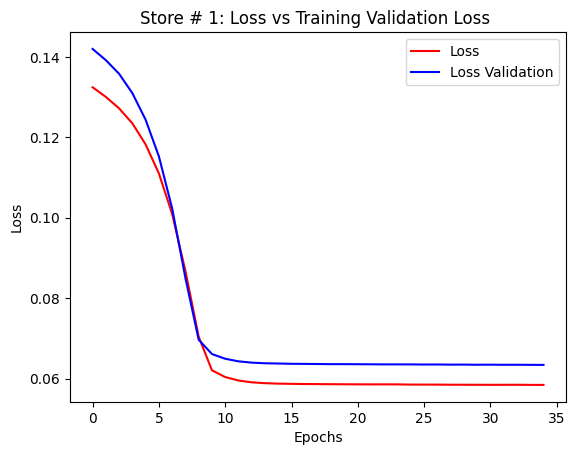

In [434]:
# Set up function to train just store #1
trainAllStores(model, 2, num_epochs, batch_size, start_bounds, middle_bounds, sequence_length)


12/12 [==============================] - 0s 966us/step


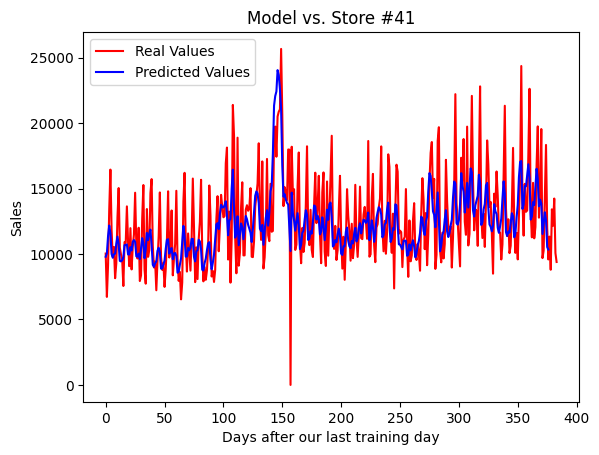

In [435]:
# Use model to predict store #41
store_num = 41
predictOneStore(model, store_num, start_bounds, middle_bounds)

Here I will train the model on 20 additional stores and predict store #41 again.

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0584 - val_loss: 0.0634
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0634
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0634
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0634
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0634
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0634
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0634
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0634
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0634
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0634
Epoch 11/35
24/24 [

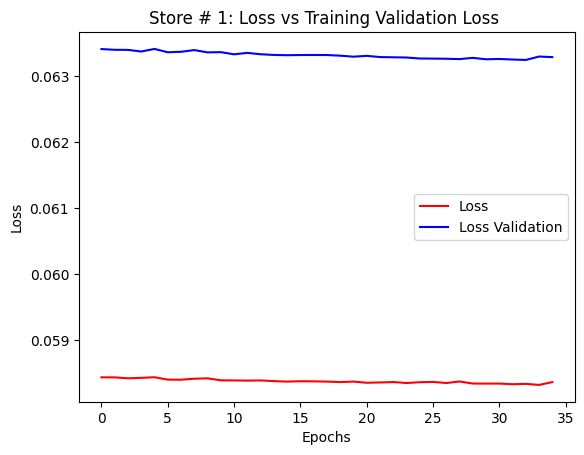

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0602 - val_loss: 0.0101
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0602 - val_loss: 0.0101
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0602 - val_loss: 0.0102
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0602 - val_loss: 0.0103
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0602 - val_loss: 0.0103
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0602 - val_loss: 0.0103
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0602 - val_loss: 0.0103
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0602 - val_loss: 0.0104
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0601 - val_loss: 0.0105
Epoch 10/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0601 - val_loss: 0.0102
Epoch 11/35
24/24 [

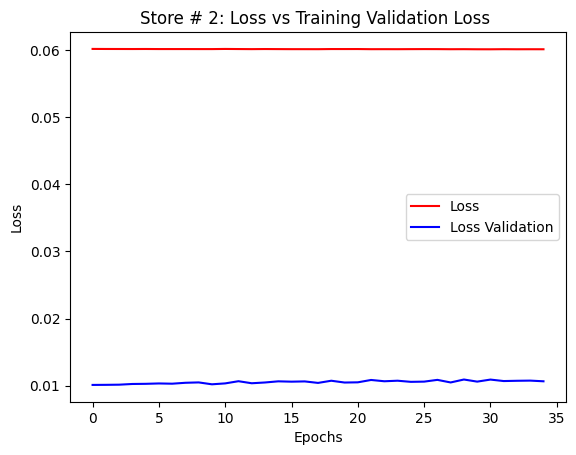

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0541 - val_loss: 0.0741
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0741
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0741
Epoch 4/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0541 - val_loss: 0.0741
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0741
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0741
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0741
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0741
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0741
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0741
Epoch 11/35
24/24 [

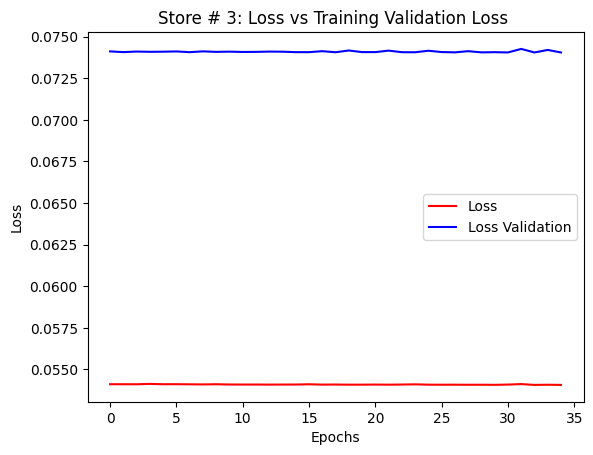

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0458 - val_loss: 0.0692
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0691
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0692
Epoch 4/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0458 - val_loss: 0.0692
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0692
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0691
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0692
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0691
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0692
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0691
Epoch 11/35
24/24 [

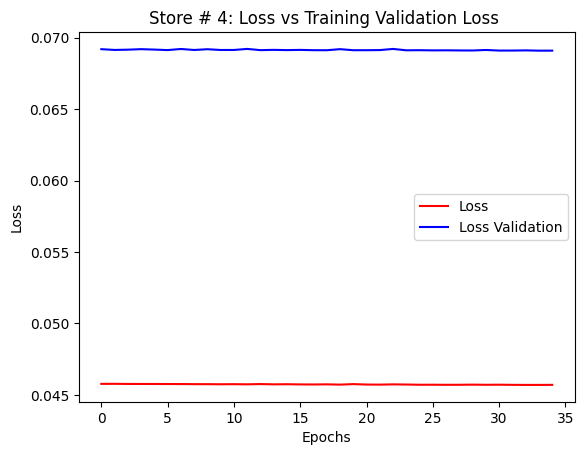

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0426 - val_loss: 0.0669
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0669
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0669
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0669
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0669
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0669
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0668
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0669
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.0668
Epoch 10/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0426 - val_loss: 0.0668
Epoch 11/35
24/24 [

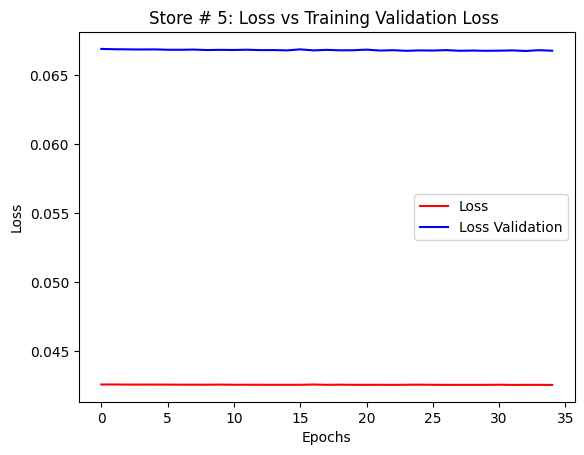

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0634
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0634
Epoch 3/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0634
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0634
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0634
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0634
Epoch 7/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0502 - val_loss: 0.0634
Epoch 8/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0502 - val_loss: 0.0634
Epoch 9/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0502 - val_loss: 0.0634
Epoch 10/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0502 - val_loss: 0.0633
Epoch 11/35
24/24 [

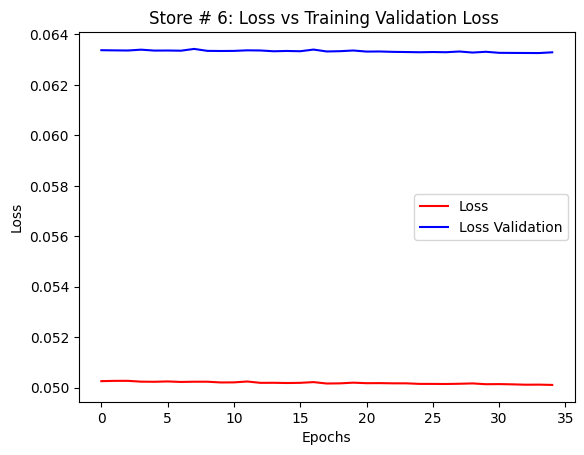

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0558 - val_loss: 0.0750
Epoch 2/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0557 - val_loss: 0.0750
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0750
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0750
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0749
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0750
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0750
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0749
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0750
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0749
Epoch 11/35
24/24 [

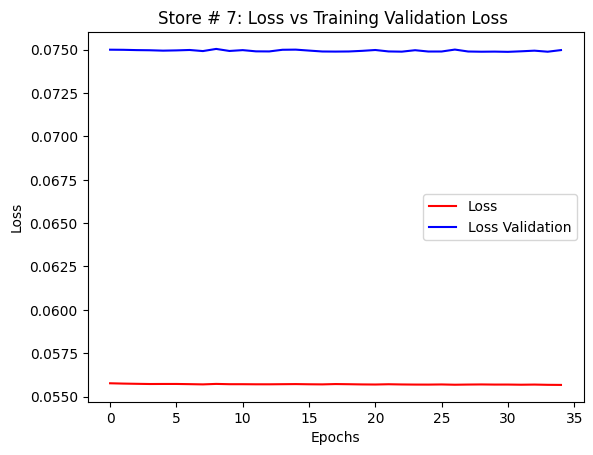

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0580 - val_loss: 0.0754
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0579 - val_loss: 0.0754
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0579 - val_loss: 0.0754
Epoch 4/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0579 - val_loss: 0.0754
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0579 - val_loss: 0.0754
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0579 - val_loss: 0.0754
Epoch 7/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0579 - val_loss: 0.0754
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0755
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0579 - val_loss: 0.0754
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0579 - val_loss: 0.0754
Epoch 11/35
24/24 [

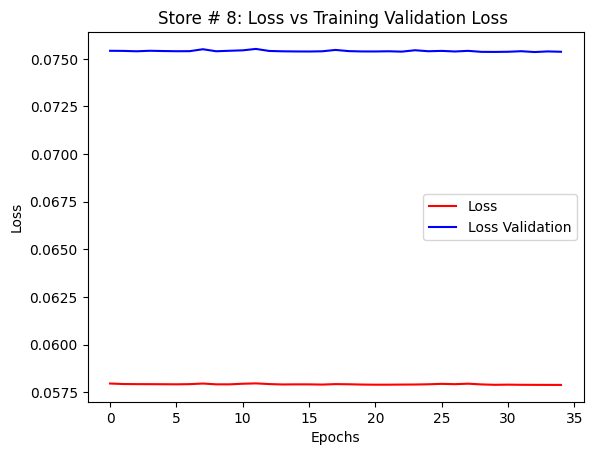

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0343 - val_loss: 0.0576
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0576
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0576
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0576
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0576
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0576
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0576
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0576
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0342 - val_loss: 0.0576
Epoch 10/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0342 - val_loss: 0.0576
Epoch 11/35
24/24 [

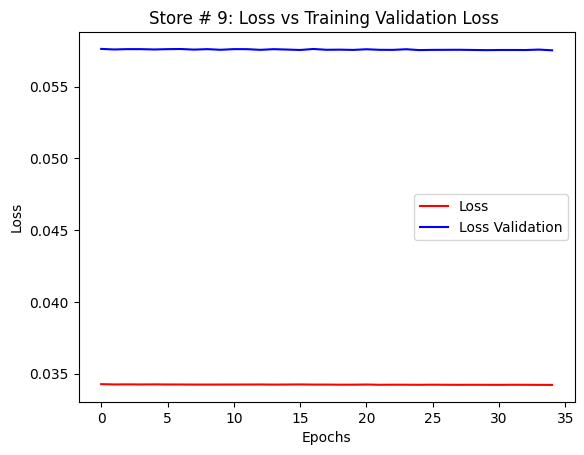

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0635 - val_loss: 0.0285
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0635 - val_loss: 0.0287
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0635 - val_loss: 0.0287
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0635 - val_loss: 0.0286
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0634 - val_loss: 0.0287
Epoch 6/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0634 - val_loss: 0.0288
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0634 - val_loss: 0.0288
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0634 - val_loss: 0.0288
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0635 - val_loss: 0.0288
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0634 - val_loss: 0.0287
Epoch 11/35
24/24 [

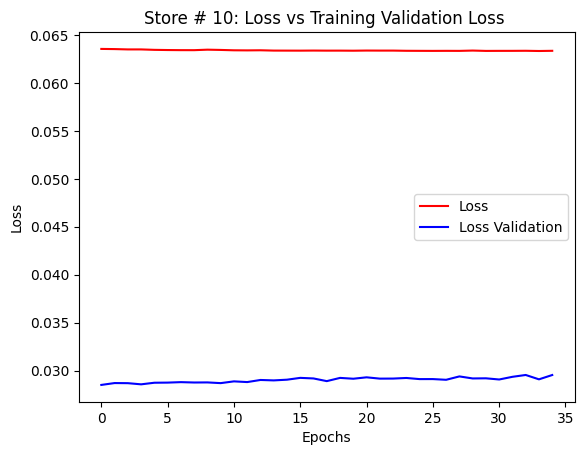

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0558 - val_loss: 0.0685
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0685
Epoch 3/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0558 - val_loss: 0.0685
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0685
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0685
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0685
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0685
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0685
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0685
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0685
Epoch 11/35
24/24 [

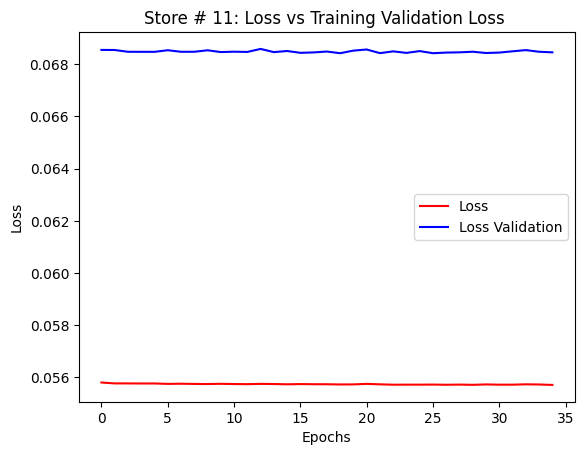

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0238 - val_loss: 0.0773
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0234 - val_loss: 0.0764
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.0756
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.0757
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.0754
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0232 - val_loss: 0.0750
Epoch 7/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0232 - val_loss: 0.0748
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0232 - val_loss: 0.0746
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0232 - val_loss: 0.0743
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0232 - val_loss: 0.0742
Epoch 11/35
24/24 [

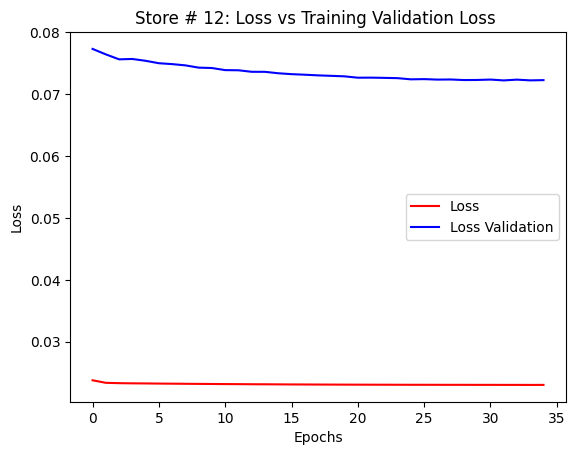

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0363 - val_loss: 0.0643
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0643
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0643
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0363 - val_loss: 0.0643
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0643
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0643
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0643
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0643
Epoch 9/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0362 - val_loss: 0.0643
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0643
Epoch 11/35
24/24 [

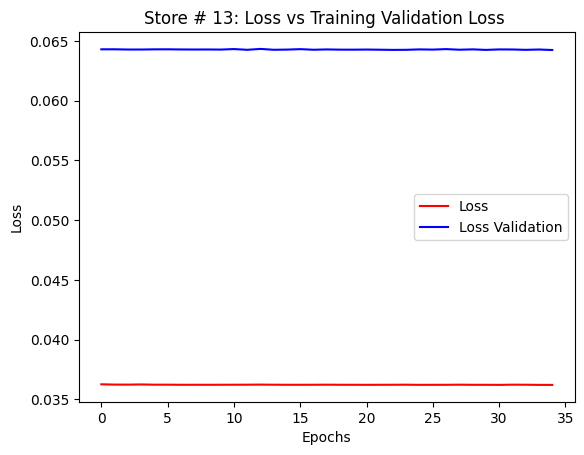

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0677
Epoch 2/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0677
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0677
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0677
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0677
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0677
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0677
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0678
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0677
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0677
Epoch 11/35
24/24 [

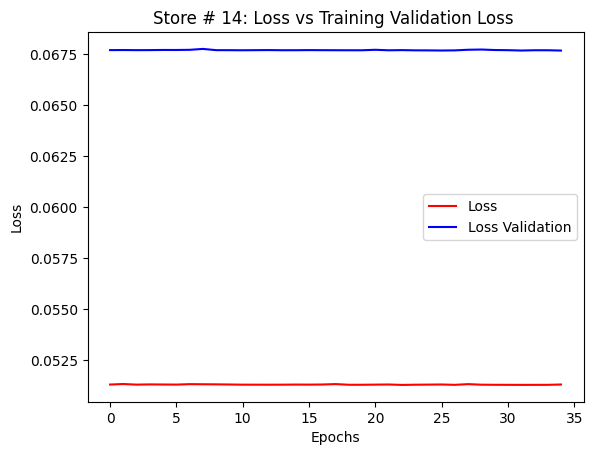

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0344 - val_loss: 0.0721
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0720
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0721
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0721
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0720
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0721
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0721
Epoch 8/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0344 - val_loss: 0.0721
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0721
Epoch 10/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0343 - val_loss: 0.0721
Epoch 11/35
24/24 [

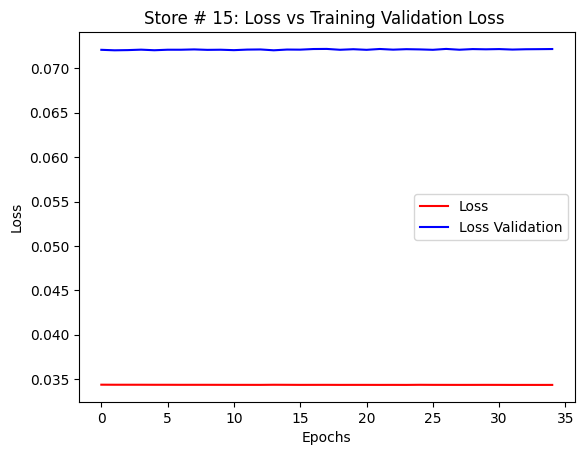

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0532 - val_loss: 0.0453
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0452
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0453
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0453
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0453
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0453
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0453
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0454
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0453
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0453
Epoch 11/35
24/24 [

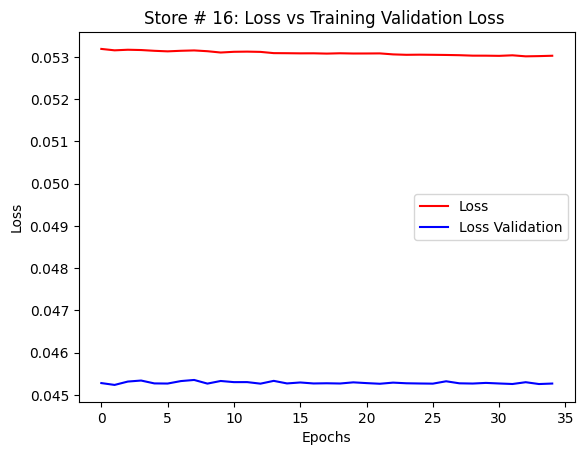

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0340 - val_loss: 0.0581
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0581
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0581
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0581
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0581
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0581
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0581
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0581
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0581
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0581
Epoch 11/35
24/24 [

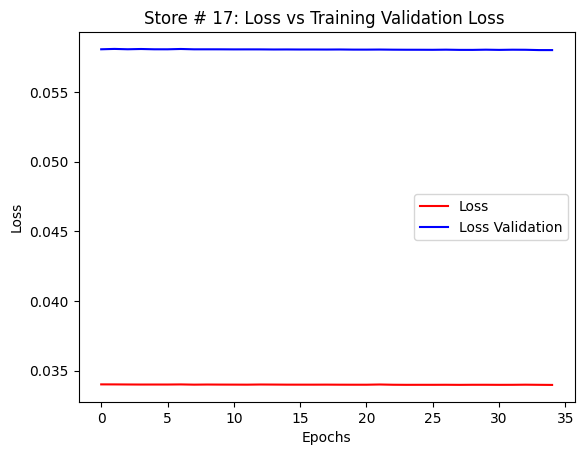

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0434 - val_loss: 0.0378
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0378
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0378
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0378
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0378
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0378
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0378
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0379
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0379
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0378
Epoch 11/35
24/24 [

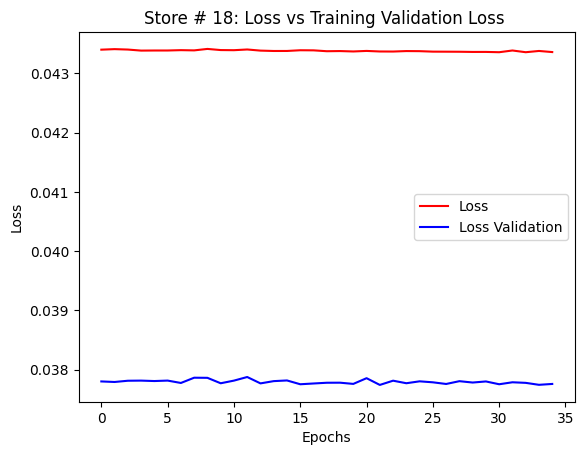

Epoch 1/35
24/24 [==============================] - 0s 4ms/step - loss: 0.0457 - val_loss: 0.0688
Epoch 2/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0688
Epoch 3/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0688
Epoch 4/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0688
Epoch 5/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0688
Epoch 6/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0688
Epoch 7/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0688
Epoch 8/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0688
Epoch 9/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0688
Epoch 10/35
24/24 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0689
Epoch 11/35
24/24 [

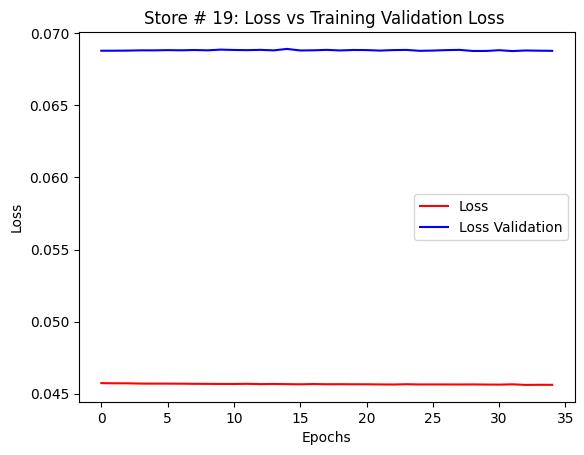

In [436]:
# Train on all stores up to num_stores
trainAllStores(model, num_stores, num_epochs, batch_size, start_bounds, middle_bounds, sequence_length)

12/12 [==============================] - 0s 756us/step


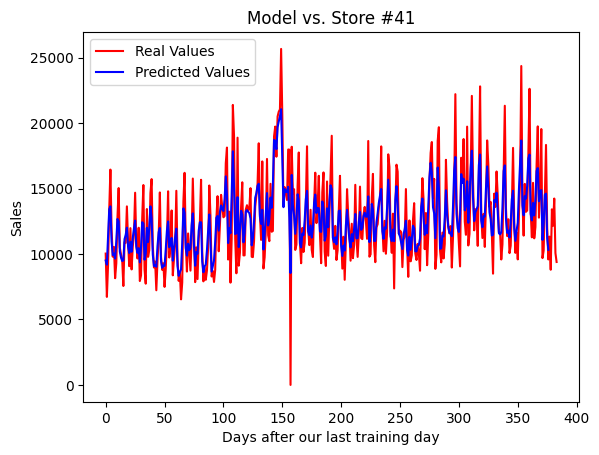

In [437]:
# Show model predictions for all stores up to num_stores
predictOneStore(model, store_num, start_bounds, middle_bounds)

We can see that, when trained on more stores, the model is able to better capture general trends in the data. In the initial test where we only trained one store #1, the model was not able to capture the smaller intricate ups and downs of the data. In addition to that, we also see that the local peak values are closer to the real local peak values and the same goes for the local minimums, generally. We can also see that the model loses sight of the very big outlier cases, as such for the data point around day 150. In our first prediction, it was able to get much closer to that specific peak value.